# Imports

In [3]:
from translate import Translator
from deep_translator import GoogleTranslator

import matplotlib.pyplot as plt
import polars as pl
import pickle
import numpy as np
import func_timeout
import plotly.graph_objects as go
from wordcloud import WordCloud

from tqdm import tqdm

# Initialize the data

In [6]:
video_id_to_ccid = pl.read_csv("./relations/video_id-ccid.txt", separator="\t", has_header=False)
video_id_to_ccid.columns = ["video_id", "ccid"]

videos_df = pl.read_ndjson("./entities/video.json")

user_video_df = pl.read_ndjson("./relations/user-video.json")

user_df = pl.read_ndjson("./entities/user.json")

courses = pl.read_ndjson("./entities/course.json")

# print("Number of videos: ", videos_df.shape[0])
# print("Number of users: ", user_video_df.shape[0])

id_to_ccid = dict(zip(list(video_id_to_ccid['video_id']), list(video_id_to_ccid['ccid'])))

concept_df = pl.read_ndjson("./entities/concept.json")

concept_video = pl.read_csv("./relations/concept-video.txt", separator="\t", has_header=False)
concept_video.columns = ["concept_id", "video_ccid"]

# Plotting Helper Functions
plt.rcParams.update({'font.size': 8})
def show_hist(values, bins, name, x_label, y_label, xlabels=None, xticks=None):
    # original_stdout = sys.stdout
    # sys.stdout = open('temp_log.txt', 'w')

    plt.figure(figsize=(8, 3.5))
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    if xlabels is not None:
        plt.xticks(xticks, xlabels)

    plt.hist(values, bins=bins)

    # sys.stdout.close()
    # sys.stdout = original_stdout
    # os.remove('temp_log.txt')

    plt.savefig(f"{name}.eps", format='eps') # Comment to not save the plot
    plt.show()

# Data Analysis

## Video viewing time

In [7]:
# Retrieve every video viewing time of correct segments
video_secs_seen = {}
for i in tqdm(range(user_video_df.shape[0])):
    user = user_video_df['user_id'][i]
    for video_watched in list(user_video_df['seq'][i]):
        if video_watched['video_id'] not in id_to_ccid:
            continue
        v_id = id_to_ccid[video_watched['video_id']]
        segments = video_watched['segment']
        if not v_id in video_secs_seen:
            video_secs_seen[v_id] = []
        total_secs = 0
        add = True
        for segment in segments:
            if (segment['end_point'] - segment['start_point']) < 0:
                add = False
            elif (segment['end_point'] - segment['start_point']) > 50_000:
                add = False
            else:
                total_secs += segment['end_point'] - segment['start_point']
        if add:
            video_secs_seen[v_id].append((user, np.round(total_secs, 2)))
        if not video_secs_seen[v_id]:
            del video_secs_seen[v_id]

  0%|          | 0/310360 [00:00<?, ?it/s]

100%|██████████| 310360/310360 [07:34<00:00, 682.76it/s] 


In [8]:
# Retrieve video total duration and remove abnormal length videos
ccids = list(videos_df['ccid'])
videos_with_ccid = []
for video in video_secs_seen:
    if video in ccids:
        videos_with_ccid.append(video)

videos_filtered = videos_df.filter(pl.col("ccid").is_in(videos_with_ccid)).select("ccid", "start", "end")

videos_duration = {}
for i in tqdm(range(videos_filtered.shape[0])):
    video_t = videos_filtered['ccid'][i]
    video_to_ord_start = list(videos_filtered['start'][i])
    video_to_ord_end = list(videos_filtered['end'][i])
    idx_ord_start = sorted(range(len(video_to_ord_start)), key=lambda i: video_to_ord_start[i])
    idx_ord_end = sorted(range(len(video_to_ord_end)), key=lambda i: video_to_ord_end[i])
    if idx_ord_start == idx_ord_end:
        video_to_ord_start = [video_to_ord_start[i] for i in idx_ord_start]
        video_to_ord_end = [video_to_ord_end[i] for i in idx_ord_end]
        videos_duration[video_t] = 0
        for i in range(len(video_to_ord_start) - 1):
            videos_duration[video_t] += video_to_ord_end[i + 1] - video_to_ord_start[i]
        if videos_duration[video_t] > 100_000 or videos_duration[video_t] <= 30:
            del videos_duration[video_t]

100%|██████████| 36932/36932 [00:10<00:00, 3621.13it/s]


In [9]:
# Remove videos attending the criteria
videos_to_remove = []
for video in video_secs_seen:
    if video not in videos_duration:
        videos_to_remove.append(video)
for video in videos_to_remove:
    del video_secs_seen[video]

for video in video_secs_seen:
    remove_idx = []
    for idx, video_info in enumerate(video_secs_seen[video]):
        user, video_secs = video_info
        if video_secs > (1.25 * videos_duration[video]):
            remove_idx.append(idx)
    remove_idx.sort(reverse=True)        
    for idx in remove_idx:
        del video_secs_seen[video][idx]
    if not video_secs_seen[video]:
        video_secs_seen[video].append(('no_user', 0))
        
video_with_concept = concept_video['video_ccid'].to_list()
del_video_no_cpt = []
for video in video_secs_seen:
    if video not in video_with_concept:
        del_video_no_cpt.append(video)

for video in del_video_no_cpt:
    del video_secs_seen[video]
    del videos_duration[video]

In [11]:
video_secs_video_avg = {}
for video in video_secs_seen:
    video_secs_video_avg[video] = np.round(sum([time for _, time in video_secs_seen[video]]) / len(video_secs_seen[video]), 2)

In [12]:
video_completion_percentage = {}
for video in video_secs_video_avg:
    video_completion_percentage[video] = min(1, np.round(video_secs_video_avg[video] / videos_duration[video], 2)) * 100

In [13]:
# Reorder data to calc user centric metrics
user_video_secs = {}
for video in video_secs_seen:
    for user, video_secs in video_secs_seen[video]:
        if not user in user_video_secs:
            user_video_secs[user] = []
        user_video_secs[user].append((video, video_secs))

In [14]:
user_video_secs_avg = {}
for user in user_video_secs:
    user_video_secs_avg[user] = np.round(sum([video_secs for _, video_secs in user_video_secs[user]]) / len(user_video_secs[user]), 2)

In [15]:
user_video_secs_percentage = {}
for user in user_video_secs:
    for video, video_secs in user_video_secs[user]:
        if not user in user_video_secs_percentage:
            user_video_secs_percentage[user] = []
        user_video_secs_percentage[user].append((video, np.round(video_secs / videos_duration[video], 2) * 100))

In [16]:
user_video_secs_percentage_avg = {}
for user in user_video_secs_percentage:
    user_video_secs_percentage_avg[user] = np.round(sum([percentage for _, percentage in user_video_secs_percentage[user]]) / len(user_video_secs_percentage[user]), 2)

In [17]:
print(f"Average video duration {np.mean(list(videos_duration.values()))}")
print(f"Std video duration {np.std(list(videos_duration.values()))}")
print("")
print(f"Average video secs {np.mean(list(video_secs_video_avg.values()))}")
print(f"Std video secs {np.std(list(video_secs_video_avg.values()))}")
print("")
print(f"Average video percentage {np.mean(list(video_completion_percentage.values()))}")
print(f"Std video percentage {np.std(list(video_completion_percentage.values()))}")
print("")
print(f"Average user video secs {np.mean(list(user_video_secs_avg.values()))}")
print(f"Std user video secs {np.std(list(user_video_secs_avg.values()))}")
print("")
print(f"Average user video percentage {np.mean(list(user_video_secs_percentage_avg.values()))}")
print(f"Std user video percentage {np.std(list(user_video_secs_percentage_avg.values()))}")

Average video duration 1101.345731480377
Std video duration 682.8839222259826

Average video secs 216.59122151974233
Std video secs 191.6887795720569

Average video percentage 22.760626665076146
Std video percentage 16.758594510896955

Average user video secs 194.4376501438192
Std user video secs 195.90542204524854

Average user video percentage 18.334070430995645
Std user video percentage 16.666919275961106


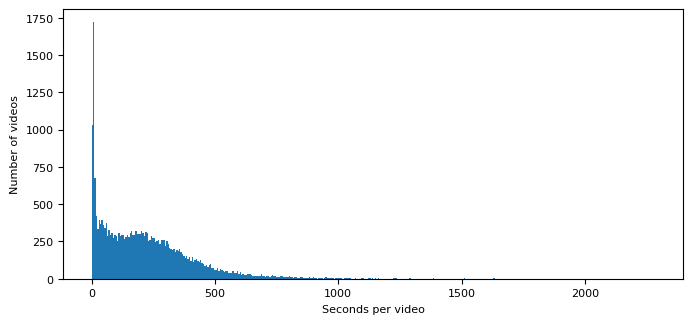

In [18]:
show_hist(video_secs_video_avg.values(), 400, "figs/video_secs_avg", "Seconds per video", "Number of videos")

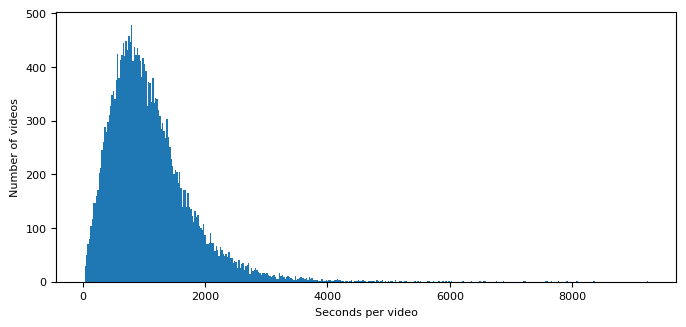

In [19]:
show_hist(videos_duration.values(), 400, "figs/video_duration", "Seconds per video", "Number of videos")

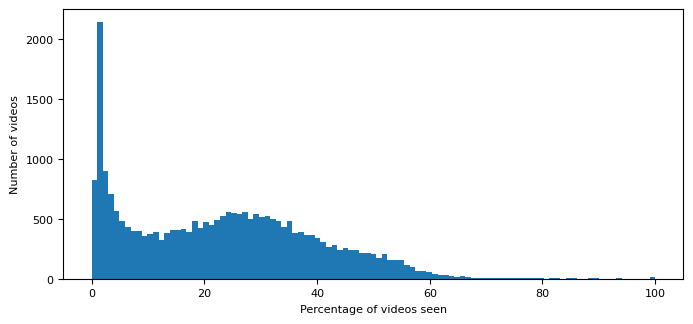

In [20]:
show_hist(video_completion_percentage.values(), 101, "figs/video_percentages", "Percentage of videos seen", "Number of videos")

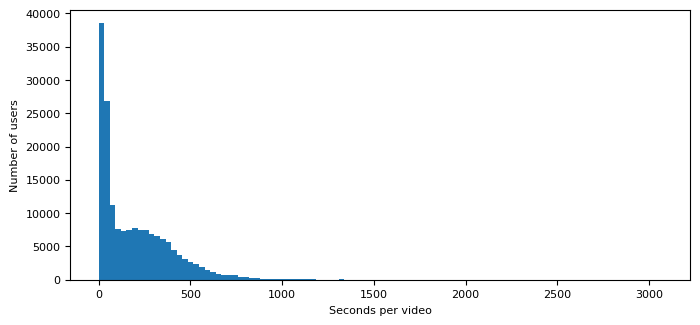

In [21]:
show_hist(user_video_secs_avg.values(), 101, "figs/user_video_secs_avg", "Seconds per video", "Number of users")

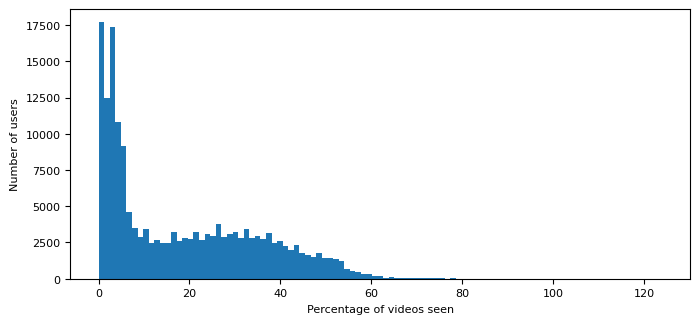

In [22]:
show_hist(user_video_secs_percentage_avg.values(), 101, "figs/user_video_percentage_avg", "Percentage of videos seen", "Number of users")

## Video Playback Speed

In [23]:
video_users_helper = {}
for video in video_secs_seen:
    video_users_helper[video] = [user for user, _ in video_secs_seen[video]]

unique_video_speed = {}
for i in tqdm(range(user_video_df.shape[0])):
    user = user_video_df['user_id'][i]
    for video_watched in list(user_video_df['seq'][i]):
        if video_watched['video_id'] not in id_to_ccid:
            continue
        v_id = id_to_ccid[video_watched['video_id']]
        if v_id not in video_secs_seen:
            continue
        if user not in video_users_helper[v_id]:
            continue
        segments = video_watched['segment']
        if v_id not in unique_video_speed:
            unique_video_speed[v_id] = []
        for segment in segments:
            unique_video_speed[v_id].append((user, segment['speed']))

100%|██████████| 310360/310360 [11:21<00:00, 455.27it/s] 


In [25]:
unique_video_speed_avg = {}
for video in unique_video_speed:
    unique_video_speed_avg[video] = np.round(sum([speed for _, speed in unique_video_speed[video]]) / len(unique_video_speed[video]), 2)

In [26]:
print("Video total average speed: " + str(np.mean(list(unique_video_speed_avg.values()))))
print("Standard deviation: " + str(np.std(list(unique_video_speed_avg.values()))))

Video total average speed: 1.292387430389817
Standard deviation: 0.28626237237962976


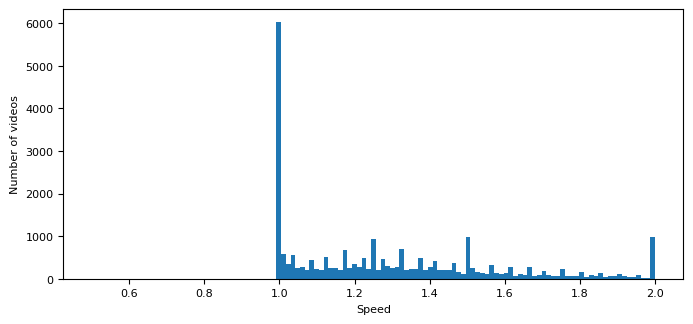

In [27]:
show_hist(unique_video_speed_avg.values(), 119, "figs/video_speed_avg", "Speed", "Number of videos")

## User Playback Speed

In [28]:
video_speed = {}
for video in tqdm(unique_video_speed):
    for user, speed in unique_video_speed[video]:
        if user not in video_speed:
            video_speed[user] = []
        video_speed[user].append((video, speed))

100%|██████████| 25140/25140 [00:05<00:00, 4391.01it/s]


In [29]:
video_speed_avg = {}
for user in video_speed:
    video_speed_avg[user] = np.round(sum([speed for _, speed in video_speed[user]]) / len(video_speed[user]), 2)

In [30]:
print("User total average speed: " + str(np.mean(list(video_speed_avg.values()))))
print("Standard deviation: " + str(np.std(list(video_speed_avg.values()))))

User total average speed: 1.2043657765994926
Standard deviation: 0.3367039791053494


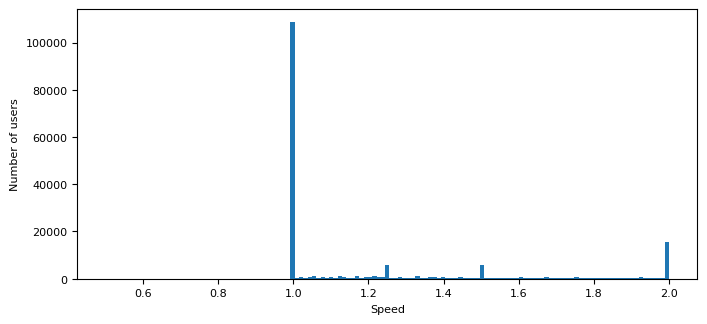

In [31]:
show_hist(video_speed_avg.values(), 131, "figs/user_video_speed", "Speed", "Number of users")

## Courses Completion Rate

In [32]:
videos_to_see = list(video_secs_seen.keys())
ccid_to_id = dict(zip(list(video_id_to_ccid['ccid']), list(video_id_to_ccid['video_id'])))

courses_info = courses.select("id", "name", "field", "resource")

videos_knowm = {}
for i in tqdm(range(courses_info.shape[0])):
    course = courses_info['id'][i]
    for resource in courses_info['resource'][i]:
        if resource['resource_id'] not in id_to_ccid:
            continue
        if id_to_ccid[resource['resource_id']] not in videos_to_see:
            continue
        video = resource['resource_id']
        if course not in videos_knowm:
            videos_knowm[course] = []
        videos_knowm[course].append(video)

course_duration = {}
for course in videos_knowm:
    videos = videos_knowm[course]
    sum_time_transcriptions = 0
    sum_time_seen = 0
    for video in videos:
        if id_to_ccid[video] not in videos_duration:
            continue
        sum_time_transcriptions += videos_duration[id_to_ccid[video]]
    course_duration[course] = np.round(sum_time_transcriptions, 2)

course_duration = dict(sorted(course_duration.items(), key=lambda item: item[1]))

100%|██████████| 3781/3781 [01:28<00:00, 42.94it/s] 


In [33]:
course_seen = {}
for course in tqdm(course_duration):
    total_time = 0
    amount_substraction = 0
    for video in videos_knowm[course]:
        video_times = video_secs_seen[id_to_ccid[video]]
        avg_video_time = np.round(sum([time for _, time in video_times]) / (len(video_times)), 2)
        total_time += avg_video_time
    course_seen[course] = np.round(total_time, 2)

100%|██████████| 880/880 [00:02<00:00, 409.82it/s] 


In [34]:
course_precentage = {}
for course in course_duration:
    course_precentage[course] = min(1, np.round(course_seen[course] / course_duration[course], 2)) * 100

In [35]:
print(f"Average course duration {np.mean(list(course_duration.values()))}")
print(f"Std course duration {np.std(list(course_duration.values()))}")
print("")
print(f"Average course secs {np.mean(list(course_seen.values()))}")
print(f"Std course secs {np.std(list(course_seen.values()))}")
print("")
print(f"Average course percentage {np.mean(list(course_precentage.values()))}")
print(f"Std course percentage {np.std(list(course_precentage.values()))}")

Average course duration 47383.00505681818
Std course duration 47737.078386144356

Average course secs 9342.078431818183
Std course secs 11507.092733466521

Average course percentage 21.05909090909091
Std course percentage 10.13090048456203


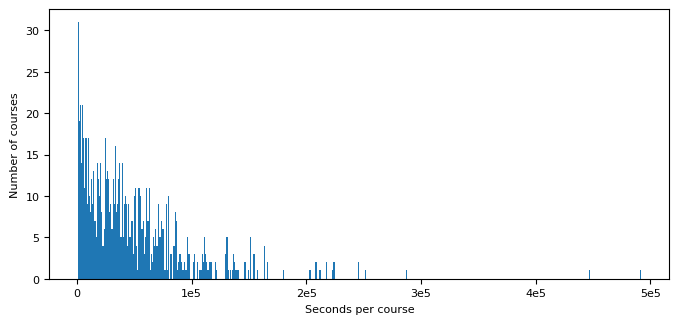

In [36]:
show_hist(course_duration.values(), 500, "figs/course_duration", "Seconds per course", "Number of courses", xlabels=['0', '1e5', '2e5', '3e5', '4e5', '5e5', '6e5', '7e5', '8e5'], xticks=[0, 100_000, 200_000, 300_000, 400_000, 500_000, 600_000, 700_000, 800_000])

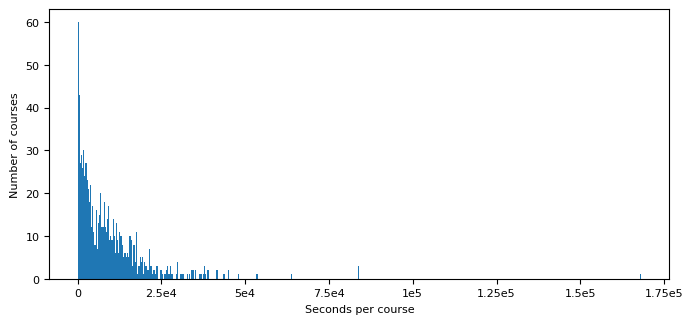

In [37]:
show_hist(course_seen.values(), 500, name="figs/course_seen", x_label="Seconds per course", y_label="Number of courses", xlabels=['0', '2.5e4', '5e4', '7.5e4', '1e5', '1.25e5', '1.5e5', '1.75e5'], xticks=[0, 25_000, 50_000, 75_000, 100_000, 125_000, 150_000, 175_000])

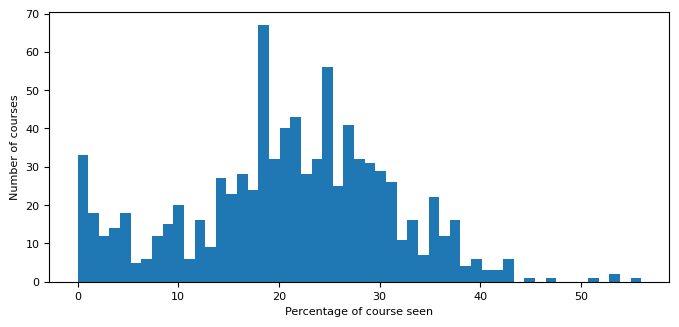

In [38]:
show_hist(list(course_precentage.values()), 53, name="figs/course_percentage", x_label="Percentage of course seen", y_label="Number of courses")

## Concepts

In [39]:
concepts_video = {}
for video in video_secs_video_avg:
    concepts_video[video] = concept_video.filter(pl.col("video_ccid") == video).select("concept_id")["concept_id"].shape[0]

In [40]:
video_keys = list(video_secs_video_avg.keys())

concepts_values = [concepts_video[video] for video in video_keys]
percentage_values = [np.round(video_completion_percentage[video], 0) for video in video_keys]
duration_values = [videos_duration[video] for video in video_keys]

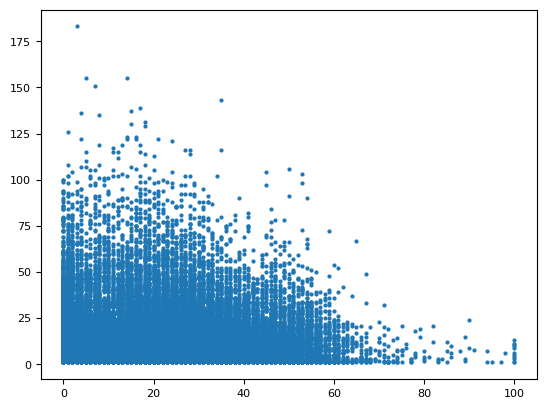

In [41]:
plt.plot(percentage_values, concepts_values, 'o', markersize=2)

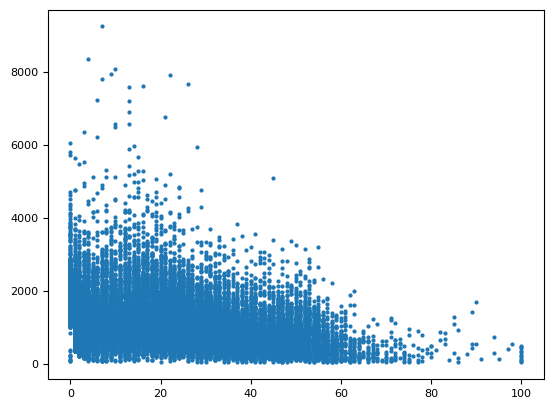

In [42]:
plt.plot(percentage_values, duration_values, 'o', markersize=2)

In [43]:
concepts_plots_df = pl.DataFrame({"percentage": percentage_values, "concepts": concepts_values, "duration": duration_values})
concepts_plots_df.write_csv("plots.csv")

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


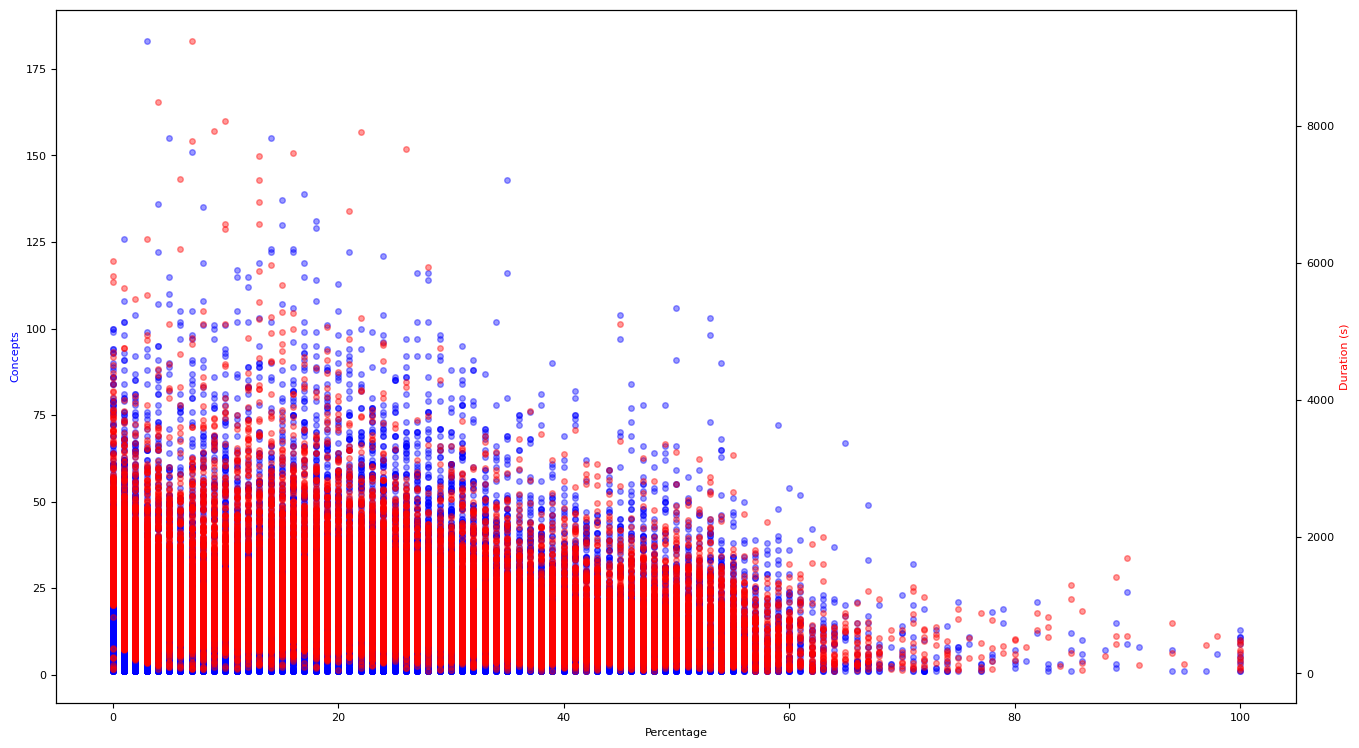

In [44]:
fig, ax1 = plt.subplots()
fig.set_figwidth(16)
fig.set_figheight(9)
ax1.plot(concepts_plots_df['percentage'], concepts_plots_df['concepts'], 'bo', alpha=0.4, markersize=4)
ax1.set_xlabel('Percentage')
ax1.set_ylabel('Concepts', color='b')

# Create the second plot with the second y-axis
ax2 = ax1.twinx()
ax2.plot(concepts_plots_df['percentage'], concepts_plots_df['duration'], 'ro', alpha=0.4, markersize=4)
ax2.set_ylabel('Duration (s)', color='r')

plt.savefig(f"figs/pcs.eps", format='eps')

plt.show()

In [45]:
limit = concepts_plots_df.shape[0]
symbols = ['circle' for _ in range(limit)]
colors = ['blue' for _ in range(limit)]
marker=dict(size=1, color=colors, opacity=0.8, symbol=symbols)

fig = go.Figure(data=[go.Scatter3d(x=concepts_plots_df['percentage'], y=concepts_plots_df['concepts'], z=concepts_plots_df['duration'], mode='markers', marker=marker)])
fig.update_layout(scene=dict(xaxis_title='Percentage ', yaxis_title='N concepts', zaxis_title='Duration (s)'), margin=dict(l=0, r=0, t=0, b=0))

fig.write_html("index.html")

fig.show()

# Translations

## Perform Translations

In [66]:
# Translators
# translator = Translator(to_lang="en", from_lang="zh")
translator = GoogleTranslator(from_lang="zh-CN", to_lang='en-US')

In [ ]:
video_translations = {}
for video in video_secs_seen:
    if video in video_translations:
        continue
    name = videos_df.filter(pl.col("ccid") == video).select("name")["name"][0]
    video_translations[video] = translator.translate(name)

In [74]:
# save video_translations in a pickle file
with open('video_translations.pkl', 'wb') as f:
    pickle.dump(video_translations, f)

In [46]:
# read video_translations.pkl
with open('video_translations.pkl', 'rb') as f:
    video_translations = pickle.load(f)

In [82]:
concept_codings = {}
field_codings = {}
prefix = 'K_'
coded_concept = 0
coded_field = 0
for i in tqdm(range(concept_video.shape[0])):
    if concept_video['video_ccid'][i] not in video_translations:
        continue
    concept = concept_video['concept_id'][i]
    values = concept.split("_")
    family = values[-1]
    name = concept.replace(prefix, "").replace("_" + family, "")
    if name not in concept_codings:
        concept_codings[name] = coded_concept
        coded_concept += 1
    if family not in field_codings:
        field_codings[family] = coded_field
        coded_field += 1

100%|██████████| 624683/624683 [00:02<00:00, 224750.18it/s]


In [84]:
field_translations = {}
for field in field_codings:
    if field in field_translations:
        continue
    field_translations[field] = translator.translate(field)

In [85]:
# save field_translations in a pickle file
with open('field_translations.pkl', 'wb') as f:
    pickle.dump(field_translations, f)

In [80]:
# read field_translations.pkl
with open('field_translations.pkl', 'rb') as f:
    field_translations = pickle.load(f)

In [90]:
concept_translations = {}
for concept in tqdm(concept_codings):
    if concept in concept_translations:
        continue
    concept_translations[concept] = translator.translate(concept)

100%|██████████| 172490/172490 [00:58<00:00, 2935.39it/s]


In [91]:
# save concept_translations in a pickle file
with open('concept_translations.pkl', 'wb') as f:
    pickle.dump(concept_translations, f)

In [88]:
# read concept_translations.pkl
with open('concept_translations.pkl', 'rb') as f:
    concept_translations = pickle.load(f)

## Translations analysis

In [49]:
most_uncompleted = sorted(video_secs_video_avg.items(), key=lambda x: x[1], reverse=False)[:9]
most_uncompleted_list = set()

In [92]:
for video, _ in most_uncompleted:
    print(video_translations[video])
    print(f"Video duration: {videos_duration[video]}")
    print(f"N concepts: {len(concept_video.filter(pl.col('video_ccid') == video).select('concept_id')['concept_id'])}")
    video_concepts = []
    for concept in concept_video.filter(pl.col("video_ccid") == video).select("concept_id")["concept_id"]:
        values = concept.split("_")
        family = values[-1]
        name = concept.replace("K_", "").replace("_" + family, "")
        video_concepts.append(concept_translations[name])
        most_uncompleted_list.add(concept_translations[name])
    video_concepts_str = ", ".join(video_concepts)
    print(f"Family: {field_translations[family]} - Concepts: {video_concepts_str}")
    
    print("------------------")

Summary of Chapter 3
Video duration: 92.459
N concepts: 1
Family: Information and Communication Engineering - Concepts: Kang Ying
------------------
3.1 Main modes of storage management
Video duration: 221.81699999999998
N concepts: 9
Family: computer science and Technology - Concepts: programming, storage management master, memory, two-dimensional address space, Partition reuse, video, Page, Main memory reuse, Main memory management mode
------------------
3.2 Functions of storage management
Video duration: 220.455
N concepts: 7
Family: computer science and Technology - Concepts: Storage management functions, storage managed, memory, OK, video, item, Main memory space
------------------
3.3 Concept of virtual memory
Video duration: 124.51400000000001
N concepts: 1
Family: computer science and Technology - Concepts: video
------------------
Chapter 15 Introduction
Video duration: 62.57000000000001
N concepts: 1
Family: computer science and Technology - Concepts: LL
------------------
V

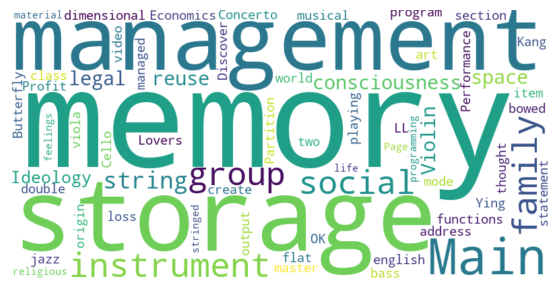

In [93]:
text = ' '.join(most_uncompleted_list)
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

plt.figure(figsize=(8, 3.5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
#plt.title('Word cloud of concepts for the less viewed videos')
# plt.savefig(f"figs/cloud_lowest.eps", format='eps')
plt.show()

In [51]:
most_seen = sorted(video_secs_video_avg.items(), key=lambda x: x[1], reverse=True)[:6]
most_seen_list = set()

In [94]:
for video, _ in most_seen:
    print(video_translations[video])
    print(f"Video duration: {videos_duration[video]}")
    print(f"Time seen: {video_secs_video_avg[video]}")
    print(f"N concepts: {len(concept_video.filter(pl.col('video_ccid') == video).select('concept_id')['concept_id'])}")
    video_concepts = []
    for concept in concept_video.filter(pl.col("video_ccid") == video).select("concept_id")["concept_id"]:
        values = concept.split("_")
        family = values[-1]
        name = concept.replace("K_", "").replace("_" + family, "")
        video_concepts.append(concept_translations[name])
        most_seen_list.add(concept_translations[name])
    video_concepts_str = ", ".join(video_concepts)
    print(f"Family: {field_translations[family]} - Concepts: {video_concepts_str}")
    
    print("------------------")

Governance collaboration
Video duration: 5101.240000000002
Time seen: 2285.4
N concepts: 104
Family: Atmospheric Science - Concepts: Ultra-low emission standards, Ultra-low emissions, Energy scenarios with continued emission reductions, Continuous emission reduction energy scenario, Continuous emission reduction scenario, Air Pollution Prevention and Control Action Plan, air pollution control, air pollution control goals, atmospheric pollutant, Air pollutant emissions, energy structure, Low carbon transportation construction system, Construction of low-carbon transportation system, Low carbon transportation system, low carbon path, low carbon energy scenario, low carbon scenario, Electric power industry emission standards, non-fossil energy, Utilization of non-fossil energy, wind, High consumption capacity, Energy Institute of the National Development and Reform Commission of the Industrial Department, energy consuming products, Medium and long-term development plan for nuclear power, 

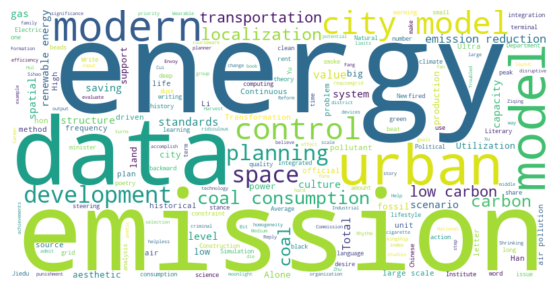

In [64]:
text = ' '.join(most_seen_list)
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

plt.figure(figsize=(8, 3.5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
#plt.title('Word cloud of concepts for the less viewed videos')
# plt.savefig(f"figs/cloud_lowest.eps", format='eps')
plt.show()

In [54]:
most_completed = sorted(video_completion_percentage.items(), key=lambda x: x[1], reverse=True)[:10]
most_completed_list = set()

In [95]:
for video, _ in most_completed:
    print(video_translations[video])
    print(f"Video duration: {videos_duration[video]}")
    print(f"Time seen: {video_secs_video_avg[video]}")
    print(f"N concepts: {len(concept_video.filter(pl.col('video_ccid') == video).select('concept_id')['concept_id'])}")
    video_concepts = []
    for concept in concept_video.filter(pl.col("video_ccid") == video).select("concept_id")["concept_id"]:
        values = concept.split("_")
        family = values[-1]
        name = concept.replace("K_", "").replace("_" + family, "")
        video_concepts.append(concept_translations[name])
        most_completed_list.add(concept_translations[name])
    video_concepts_str = ", ".join(video_concepts)
    print(f"Family: {field_translations[family]} - Concepts: {video_concepts_str}")
    
    print("------------------")

LinuxCPP0401
Video duration: 44.44
Time seen: 44.85
N concepts: 6
Family: computer science and Technology - Concepts: recursive algorithm, Fault tolerance, accomplish, Algorithm base, How to describe an algorithm, Algorithmic complexity
------------------
telescope
Video duration: 240.20000000000005
Time seen: 245.2
N concepts: 5
Family: physics - Concepts: wavelength, Resolution angle formula, observe, telescope, Shadow
------------------
1.11 System structure perspective
Video duration: 455.721
Time seen: 529.13
N concepts: 11
Family: computer science and Technology - Concepts: operating system kernel, single core, computer software, process, software engineering, entity, accomplish, video, thread, support, main body
------------------
5.1 The concept of files
Video duration: 87.41699999999999
Time seen: 100.0
N concepts: 11
Family: computer science and Technology - Concepts: Concurrent computing, step, processor, memory, multi-Progress, OK, Computer hardware, calculate, process, vid

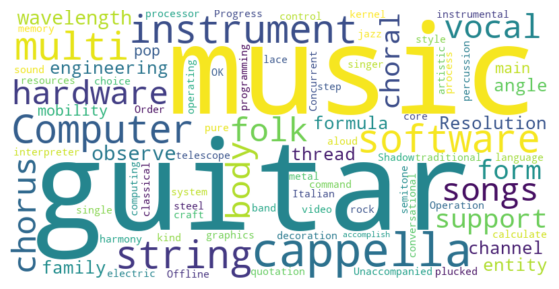

In [103]:
text = ' '.join(most_completed_list)
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

plt.figure(figsize=(8, 3.5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
#plt.title('Word cloud of concepts for the less viewed videos')
# plt.savefig(f"figs/cloud_lowest.eps", format='eps')
plt.show()